## 보스턴 집값 예측 모델
- 데이터셋 : boston.csv
- 목적 : MEDV 예측  
- 피쳐 : 13개
- 타겟 : MEDV
- 학습방법 : 지도학습 > 회귀  
- 알고리즘 : 선형관계 - 선형모델 => nn.Linear
- 프레임워크 : Pytorch

CRIM: 도시의 범죄율  
ZN: 25,000 평방 피트 이상의 주택 비율  
INDUS: 비소매 상업 지역의 비율  
CHAS: 찰스 강 경계 여부 (1: 경계, 0: 경계 아님)  
NOX: 일산화질소 농도  
RM: 주택당 평균 방 개수  
AGE: 1940년 이전에 지어진 주택     
DIS: 5개의 보스턴 고용센터까지의 가중 거리  
RAD: 고속도로 접근성 지수  
TAX: 재산세율  
PTRATIO: 지역별 학생 대 교사 비율  
B: 흑인 비율(B = 1000(Bk - 0.63)^2, Bk는 흑인의 비율)  
LSTAT: 하위 계층 비율  
MEDV: 주택 가격(중앙값)  

[1] 모듈로딩

In [31]:
import torch                    #텐서 및 수치 계산 함수 관련모듈
import torch.nn as nn           # 인공신경망 관련 모듈
import torch.nn.functional as F # 손길, 거리 등 함수 관련 모듈
import torch.optim as optimizer # 최적화 기법 관련 모듈
import pandas as pd         
from sklearn.model_selection import train_test_split    
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

[2] 데이터 준비

In [32]:
# 랜덤 시드 설정
torch.manual_seed(1)

In [33]:
# 데이터 로딩 csv => DataFrame
FILE_PATH = r'C:\baekjoon-solutions\연습\boston.csv'

df=pd.read_csv(FILE_PATH)
df.head(2)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.9,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.9,9.14,21.6


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


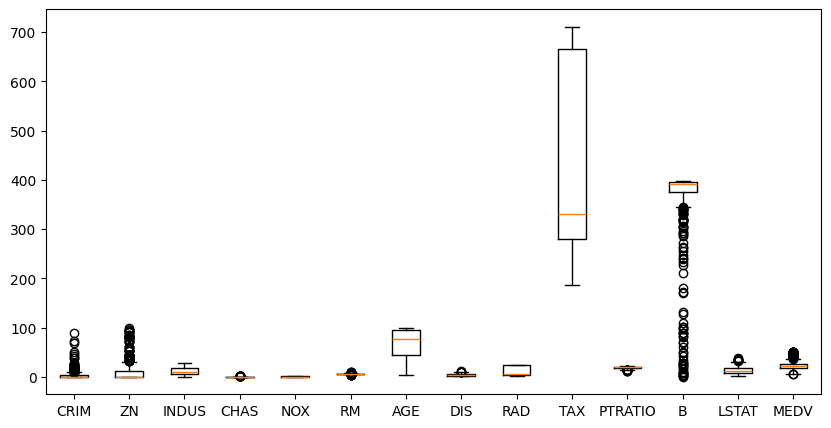

In [35]:
# 박스플롯
plt.figure(figsize = (10, 5))
plt.boxplot(df.iloc[:, :14])
plt.xticks(np.arange(1,15), df.columns[:14])
plt.show()

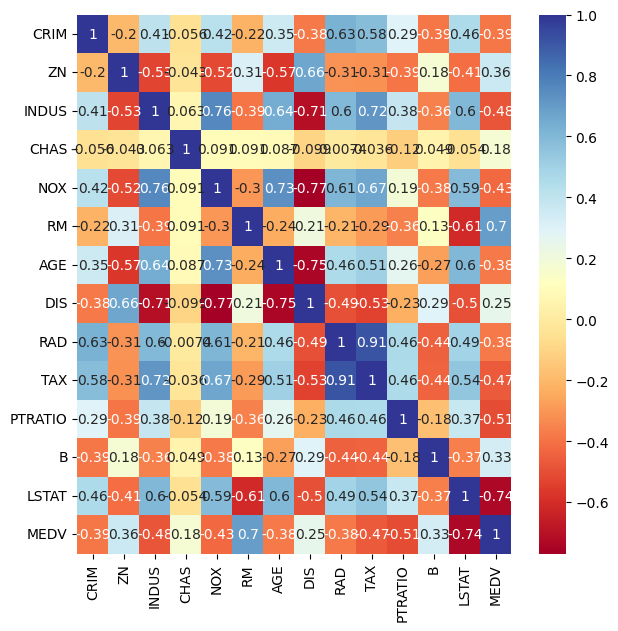

In [36]:
plt.figure(figsize=(7,7))
g = sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='RdYlBu')
plt.show()

[3] 모델 준비

In [37]:
# in_features : CRIM, ZN, INDUS, CHAS, NOX, RM, AGE, DIS, RAD, TAX , PTRATIO, B	, LSTAT
# out_features : MEDV

model = nn.Linear(13,1)

In [38]:
# 가중치와 절편 확인
for name, param in model.named_parameters():
    print(f'[{name}] {param}\n')

[weight] Parameter containing:
tensor([[ 0.1429, -0.1224, -0.0538,  0.1302, -0.2611,  0.1663, -0.0571,  0.1411,
          0.0386, -0.0340,  0.0769,  0.0137,  0.1013]], requires_grad=True)

[bias] Parameter containing:
tensor([-0.1081], requires_grad=True)



[4] 최적화 인스턴스 준비

In [39]:
## 모델의 가중치와 절편을 최적화 ==> 인스턴스에 전달
adam_optim=optimizer.Adam(model.parameters(), lr=0.1)

[5] 학습 ==> 개발자가 구현

[5-1] 데이터셋 Tensor화 진행 : 데이터준비 시 진행하거나 학습 전 진행

In [40]:
featureTS=torch.from_numpy(df[df.columns[:-1]].values).float() 
featureTS.shape

torch.Size([506, 13])

In [41]:
targetTS=torch.from_numpy(df[['MEDV']].values).float() # 2차원
targetTS.shape

torch.Size([506, 1])

[5-2] 학습,검증, 테스트데이터셋 분리

In [42]:
# Train & Test
X_train, X_test, y_train, y_test = train_test_split(featureTS, targetTS, test_size=0.2)

# Train & Valid
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

print(f'[Feature] Train {X_train.shape}, TEST { X_test.shape}, VAL {X_val.shape}')
print(f'[Target] Train {y_train.shape}, TEST { y_test.shape}, VAL {y_val.shape}')

[Feature] Train torch.Size([323, 13]), TEST torch.Size([102, 13]), VAL torch.Size([81, 13])
[Target] Train torch.Size([323, 1]), TEST torch.Size([102, 1]), VAL torch.Size([81, 1])


[5-3] 학습 진행
- 에포크 => 학습횟수
- loss => 학습결과(손실저장)

In [43]:
EPOCH=100

In [44]:
## 테스트/검증 함수 
# ==> 가중치, 절편 업데이트 X, 최적화 미진행
# ==> 현재 가중치와 절편값으로 테스트 진행
# 모델 학습 함수
def testing(testTS,targetTS, kind='Val'):

    with torch.no_grad():    # 가중치 및 절편 업데이트 진행 X
        #-(1)학습진행 - forward
        pre_y=model(testTS)
        #-(2)오차계산 - 손실함수
        loss=F.mse_loss(pre_y, targetTS)
 
        #-(4)학습결과 출력 및 저장
        print(f'[{kind}] LOSS: {loss}')
    return loss

In [45]:
# 모델 학습 함수
def training(featureTS, targetTS, valTS, valTargetTS, testTS, testtargetTS):

    loss_history=[[],[], []]
    for epoch in range(EPOCH):
        #-(1)학습진행 - forward
        pre_y=model(featureTS)
        #-(2)오차계산 - 손실함수
        loss=F.mse_loss(pre_y, targetTS)
        loss_history[0].append(loss.item())
        
        #-(3)최적화 - 가중치,절편 업데이트 backward
        adam_optim.zero_grad() #gradient를 0으로 초기화
        loss.backward() #  오차 미분, 비용 함수를 미분하여 gradient 계산
        adam_optim.step() #  가중치 업데이트 W와 b를 업데이트

        #-(4)검증 - 모댈이 제대로 만들어지는 검사용
        val_loss = testing(valTS, valTargetTS)
        loss_history[1].append(val_loss.item())

        #-(5)테스트 - 테스트 결과 저장
        test_loss = testing(testTS, testtargetTS)
        loss_history[2].append(test_loss.item())
        
        #-(6)학습결과 출력 및 저장
        print(f'[{epoch}/{EPOCH}] LOSS: {loss}')

    return loss_history

In [46]:
# 모델 학습 진행
loss = training(X_train, y_train, X_val, y_val, X_test, y_test)

[Val] LOSS: 3670.322265625
[Val] LOSS: 3738.847412109375
[0/100] LOSS: 1113.0048828125
[Val] LOSS: 837.072998046875
[Val] LOSS: 856.4998168945312
[1/100] LOSS: 3870.703125
[Val] LOSS: 478.0687255859375
[Val] LOSS: 405.42401123046875
[2/100] LOSS: 911.7374267578125
[Val] LOSS: 1966.7437744140625
[Val] LOSS: 1848.9749755859375
[3/100] LOSS: 408.8625793457031
[Val] LOSS: 1426.5516357421875
[Val] LOSS: 1350.6812744140625
[4/100] LOSS: 1851.4117431640625
[Val] LOSS: 245.2712860107422
[Val] LOSS: 227.0587921142578
[5/100] LOSS: 1356.07861328125
[Val] LOSS: 260.594970703125
[Val] LOSS: 263.68280029296875
[6/100] LOSS: 234.19720458984375
[Val] LOSS: 978.5952758789062
[Val] LOSS: 971.5654907226562
[7/100] LOSS: 280.6369934082031
[Val] LOSS: 991.2618408203125
[Val] LOSS: 977.6806640625
[8/100] LOSS: 998.0084838867188
[Val] LOSS: 376.1316223144531
[Val] LOSS: 370.6531982421875
[9/100] LOSS: 1001.1598510742188
[Val] LOSS: 70.49226379394531
[Val] LOSS: 76.21802520751953
[10/100] LOSS: 383.760498046

In [47]:
loss # epoch 가 10이여서 

[[1113.0048828125,
  3870.703125,
  911.7374267578125,
  408.8625793457031,
  1851.4117431640625,
  1356.07861328125,
  234.19720458984375,
  280.6369934082031,
  998.0084838867188,
  1001.1598510742188,
  383.760498046875,
  83.7470932006836,
  393.6083068847656,
  696.0593872070312,
  521.0828857421875,
  163.24024963378906,
  104.22710418701172,
  335.3416442871094,
  450.93115234375,
  284.309814453125,
  90.3804931640625,
  118.0506362915039,
  268.78924560546875,
  288.82598876953125,
  155.6306915283203,
  69.05160522460938,
  130.60397338867188,
  212.36251831054688,
  179.01072692871094,
  88.20903015136719,
  73.75572967529297,
  134.56094360351562,
  156.64804077148438,
  104.59446716308594,
  63.350067138671875,
  87.91336059570312,
  121.97366333007812,
  103.9905776977539,
  66.08450317382812,
  67.59243774414062,
  94.67459106445312,
  94.24945831298828,
  67.7930908203125,
  60.16976547241211,
  77.48309326171875,
  82.80194854736328,
  66.05396270751953,
  57.059566497

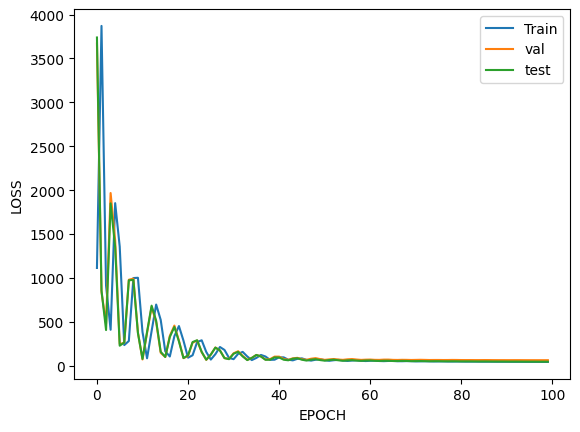

In [48]:
# 학습 후 loss 시각화

plt.plot(range(EPOCH),loss[0], label ='Train')
plt.plot(range(EPOCH),loss[1], label='val')
plt.plot(range(EPOCH),loss[2], label='test')
plt.xlabel('EPOCH')
plt.ylabel('LOSS')
plt.legend()
plt.show()

[6] StandardScaler 사용

In [49]:
from sklearn.preprocessing import StandardScaler

In [50]:
# Train & Test
X_train, X_test, y_train, y_test = train_test_split(featureTS, targetTS, test_size=0.2)

# Train & Valid
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)


In [51]:
scaler=StandardScaler()
X_train_scaled= scaler.fit_transform(X_train)

In [52]:
X_val_scaled = scaler.transform(X_val) 
X_test_scaled = scaler.transform(X_test)

In [59]:
# 넘파이를 텐서로 바꿔줌
X_train_tensor = torch.from_numpy(X_train_scaled).float()
X_val_tensor = torch.from_numpy(X_val_scaled).float()
X_test_tensor = torch.from_numpy(X_test_scaled).float()

In [60]:
# 모델 학습 진행
loss_scaled = training(X_train_tensor, y_train, X_val_tensor, y_val, X_test_tensor, y_test)

[Val] LOSS: 661.9292602539062
[Val] LOSS: 507.4188232421875
[0/100] LOSS: 527.7173461914062
[Val] LOSS: 658.3360595703125
[Val] LOSS: 505.60052490234375
[1/100] LOSS: 526.2100830078125
[Val] LOSS: 653.4461059570312
[Val] LOSS: 503.1429138183594
[2/100] LOSS: 523.5631103515625
[Val] LOSS: 647.4744262695312
[Val] LOSS: 500.1436462402344
[3/100] LOSS: 519.9515991210938
[Val] LOSS: 640.6113891601562
[Val] LOSS: 496.6893310546875
[4/100] LOSS: 515.5337524414062
[Val] LOSS: 633.025390625
[Val] LOSS: 492.855224609375
[5/100] LOSS: 510.4498291015625
[Val] LOSS: 624.8641357421875
[Val] LOSS: 488.7047424316406
[6/100] LOSS: 504.8228454589844
[Val] LOSS: 616.25732421875
[Val] LOSS: 484.29022216796875
[7/100] LOSS: 498.7598571777344
[Val] LOSS: 607.31787109375
[Val] LOSS: 479.653564453125
[8/100] LOSS: 492.3525390625
[Val] LOSS: 598.1439208984375
[Val] LOSS: 474.8271179199219
[9/100] LOSS: 485.67889404296875
[Val] LOSS: 588.8203125
[Val] LOSS: 469.8350830078125
[10/100] LOSS: 478.80462646484375
[V

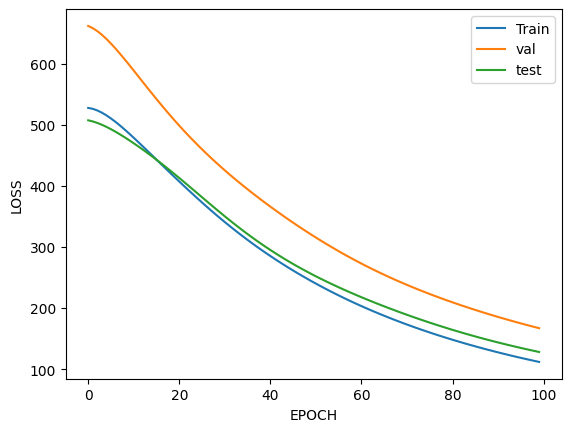

In [61]:
# 학습 후 loss 시각화

plt.plot(range(EPOCH),loss_scaled[0], label ='Train')
plt.plot(range(EPOCH),loss_scaled[1], label='val')
plt.plot(range(EPOCH),loss_scaled[2], label='test')
plt.xlabel('EPOCH')
plt.ylabel('LOSS')
plt.legend()
plt.show()

스케일링을 하기전이 그래프가 초기 손실 값이 매우 크며 손실이 크게 변동하고 있다. 이것은 모델이 학습할 때 불안정하게 손실 값을 갱신하고 있다는 것을 의미하는것 같다.  
반면 스케일링을 한다면 초반 손실값이 훨씬 작고 손실값이 점점낮아지는것을 볼 수있다.  
그래서 스케일링을 하면 좋지않을까?